## Table of Contents

**Part 1: Data Cleaning, EDA and Feature Engineering** 
- Train Data Cleaning, EDA and Feature Engineering
- Weather Data Cleaning, EDA and Feature Engineering
- Spray Data Cleaning, EDA and Feature Engineering
- Combined EDA and Feature Engineering

**Part 2: Feature Selection and Preprocessing** 
- Feature Selection
- Pre-processing

**Part 3: Modelling**
- Model Fit and Testing
- Model Iteration
- Model Evaluation
- Conclusion & Recommending

### Module Imports

In [1]:
# Standard imports
import numpy as np # Version 1.20.1
import pandas as pd # Version 1.2.4
# Pandas settings
pd.set_option('display.max_rows', None)
pd.set_option("display.max_columns", None)

# Time Series imports
import datetime as dt # Version 2.8.1
import pytz # Version 2021.1
import suntime as st # Version 1.2.5

# Plotting imports
import seaborn as sns # Version 0.11.1
import matplotlib.pyplot as plt # Version 3.3.4
import matplotlib.dates as mdates # Version 3.3.4
plt.style.use('ggplot')

# Geographical imports
import haversine as hs # Version 2.5.1
from haversine import Unit

### Function Definitions

In [2]:
# Plotting Functions
def subplot_hist(dataframe,list_of_columns, suptitle, list_of_titles,datafigsize):
    fig, ax = plt.subplots((len(list_of_columns)//2), 2,figsize= datafigsize) 
    fig.suptitle(suptitle,fontsize=30)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    plt.tight_layout(h_pad = 2,pad=5);
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ax[i].hist(dataframe[column],color="lightblue") 
        ax[i].set_title(list_of_titles[i],fontdict={'fontsize': 15})
        ax[i].xaxis.set_visible(True)
        ax[i].axvline(dataframe[column].mean(), color='r', linestyle='dashed', linewidth=1,label='mean')
        ax[i].axvline(dataframe[column].median(), color='b', linestyle='dashed', linewidth=1,label="median")
        ax[i].legend(loc='upper right');

def subplot_line(col_name, df):
    df.groupby(by = ['Year','Month'])[col_name].mean().plot(title = f'Mean {col_name} values for each month in each year ',figsize = (12,4))
    pd.pivot_table(df.reset_index(),index='Month', columns='Year', values=col_name).plot(subplots=False,
    sharey = True, sharex = True, figsize = (15,10), ylabel = col_name, xlabel = 'Month');


In [3]:
# String mapper 
def m_t_mapper(df,columns):
    for i in columns:
        df[i] = df[i].apply(lambda x: np.nan if x =='M' else x)# replace values with 'M' as np.nan
        df[i] = df[i].apply(lambda x: 0 if x =='  T' else x) # replace values with 'T' as 0     
        df[i] = df[i].astype('float') # Convert dataype of index as float
        
# Median imputer
def median_imputer(df,columns):
    for i in columns:
        df[i].fillna(df[i].median(), inplace = True)
        # replace np.nan values with median value of column
        
# Mean imputer
def mean_imputer(df,columns):
    for i in columns:
        df[i].fillna(df[i].mean(), inplace = True)
        # replace np.nan values with mean value of column

### Read CSVs

In [4]:
weather = pd.read_csv('../data/weather.csv')

In [5]:
weather.shape

(2944, 22)

In [6]:
# checking for duplicated rows
weather.duplicated().sum()

0

In [7]:
weather.columns

Index(['Station', 'Date', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth',
       'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed'],
      dtype='object')

In [8]:
# View first 5 rows in the dataframe
weather.head(5)
# click ... below to see output

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


Here are some information on each of the stations, from [Kaggle](https://www.kaggle.com/competitions/predict-west-nile-virus/data)
- **Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT**
    - Lat: 41.995 
    - Lon: -87.933 
    - Elev: 662 ft. above sea level  

- **Station 2: CHICAGO MIDWAY INTL ARPT**
    - Lat: 41.786 
    - Lon: -87.752 
    - Elev: 612 ft. above sea level

In [9]:
# Calculating Haversine Distance between the two stations
stn1 = (41.995, -87.933)
stn2 = (41.786, -87.752)
dist_btw_stn1_stn2 = hs.haversine(stn1,stn2,unit=Unit.KILOMETERS)
print(f' The distance between Station 1 and 2 in kilometers is {round(dist_btw_stn1_stn2,2)}km.')

 The distance between Station 1 and 2 in kilometers is 27.65km.


In [10]:
# Info shows us the datatypes for each columns, presence of null values as well as the column names
weather.info()
# click ... below to see output

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

### Data Cleaning

According to this part regarding column descriptions in "noaa_weather_qclcd_documentation", 

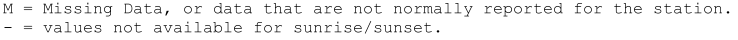

From our `weather.info()`, we also note that the 'Date' column is classified as object which is incorrect, let us deal with the 'Date' column first to prevent issues later on when we perform batch processing of the remaining 'object' columns. 


In [11]:
# Showing unique values for all columns
for col in weather.columns:
    print(f"{col}:")
    print(weather[col].unique())
    print('\n')
# Click ... below to see output

Station:
[1 2]


Date:
['2007-05-01' '2007-05-02' '2007-05-03' ... '2014-10-29' '2014-10-30'
 '2014-10-31']


Tmax:
[ 83  84  59  60  66  67  78  68  82  80  77  76  70  73  64  65  69  90
  62  61  71  79  87  89  88  75  85  86  81  72  63  91  92  93  74  94
  54  53  56  57  58  55  50  95  52  47  45  51  48  44  49  46  96  99
 100 101  97  98 102 103 104  42  41]


Tmin:
[50 52 42 43 46 48 49 51 53 54 47 60 61 63 56 59 44 57 45 55 66 65 70 68
 62 67 64 58 71 69 73 75 72 74 39 41 40 37 34 38 35 36 33 31 32 76 77 29
 78 79 80 81 82 83]


Tavg:
['67' '68' '51' '52' '56' '58' 'M' '60' '59' '65' '70' '69' '71' '61' '55'
 '57' '73' '72' '53' '62' '63' '74' '75' '78' '76' '77' '66' '80' '64'
 '81' '82' '79' '85' '84' '83' '50' '49' '46' '48' '45' '54' '47' '44'
 '40' '41' '38' '39' '42' '37' '43' '86' '87' '89' '92' '88' '91' '93'
 '94' '90' '36']


Depart:
['14' 'M' '-3' ' 2' ' 4' ' 5' '10' '12' '13' '-2' '15' '11' '-4' '-6' ' 8'
 '-5' ' 1' ' 9' ' 6' '-9' '-8' ' 3' ' 0' '-1' '-7' ' 7'

It also seems that we have quite a few columns which are not typed properly as a consequence of having "M" values causing them to be classfied as 'object' columns when the remaining values are numerical in nature.   
`Sunset` and `Sunrise` also have a `-` value, which seem to only come from data logged by Station 2.   
With reference to the earlier document, 
  
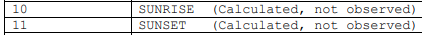  
  
  
it seems that `Sunset` and `Sunrise` are [calculated](https://gml.noaa.gov/grad/solcalc/solareqns.PDF) instead of observed. Let's see if we are able to calculate the `Sunset` and `Sunrise` times with the help of external libraries and use the calculated values for imputation. 

In [12]:
# Converting dtype of 'Date' column to 'datetime'
weather['Date'] = pd.to_datetime(weather['Date'],format='%Y-%m-%d %H:%M')

In [13]:
# Initializing Sun object with lat. long. values of station 2
s = st.Sun(stn2[0],stn2[1])
# Storing UTC as our timezone
utc = pytz.timezone('US/Central')

# Initializing empty lists to store sunrise/sunset times for given dates
sunrise_list = []
sunset_list = []
for value in weather['Date']:
    abd = value
    abd_sr = s.get_local_sunrise_time(value, local_time_zone=utc)
    abd_sr = abd_sr - abd_sr.dst()
    abd_ss = s.get_local_sunset_time(value, local_time_zone=utc)
    abd_ss = abd_ss - abd_ss.dst()
    sunrise_list.append(abd_sr.strftime('%H%M'))
    sunset_list.append(abd_ss.strftime('%H%M'))

# Impute values
index = weather.loc[weather['Station']==2].index
for i in index:
    weather.loc[i, 'Sunrise'] = sunrise_list[i]
    weather.loc[i, 'Sunset'] = sunset_list[i]

As such, while `weather.info()` might not show any missing data at first glance, we need to look closer at the columns which contains "M" values as they are actually missing data. To facilitate processing, we will map these "M" values as `np.nan`. On top of that M also denotes data not recorded at a particular station.

In [14]:
cols_to_fill = ['Tavg', 'Depart', 'WetBulb', 'Heat', 'Cool', 'Depth','Water1', 'SnowFall','PrecipTotal','StnPressure','SeaLevel','AvgSpeed']
m_t_mapper(weather,cols_to_fill)

In [15]:
cols_to_flt = ['Tmax','Tmin','DewPoint','ResultDir']
for col in cols_to_flt:
    weather[col].astype('float')

In [16]:
# Descriptive statistics for numerical columns in weather df
weather.describe().T
# click ... below to see output

,count,mean,std,min,25%,50%,75%,max
Station,2944.0,1.500000,0.500085,1.00,1.00,1.50,2.00,2.00
Tmax,2944.0,76.166101,11.461970,41.00,69.00,78.00,85.00,104.00
Tmin,2944.0,57.810462,10.381939,29.00,50.00,59.00,66.00,83.00
Tavg,2933.0,67.240027,10.545442,36.00,60.00,69.00,75.00,94.00
Depart,1472.0,1.954484,6.841110,-17.00,-3.00,2.00,7.00,23.00
DewPoint,2944.0,53.457880,10.675181,22.00,46.00,54.00,62.00,75.00
WetBulb,2940.0,59.310884,9.286742,32.00,53.00,61.00,67.00,78.00
Heat,2933.0,3.407092,5.953203,0.00,0.00,0.00,5.00,29.00
Cool,2933.0,5.647119,6.105087,0.00,0.00,4.00,10.00,29.00
Depth,1472.0,0.000000,0.000000,0.00,0.00,0.00,0.00,0.00


In [17]:
# Save the columns with null values count/ as percentage of rows in dataframe
mv_cols_count = weather.isnull().sum().sort_values(ascending=False)
mv_cols_percent = weather.isnull().sum().sort_values(ascending=False)/len(weather) * 100
# Filtering out cols with no missing values
mv_cols_count = mv_cols_count[mv_cols_count.values > 0]
mv_cols_percent = mv_cols_percent[mv_cols_percent.values > 0]

In [18]:
# Concatenating both columns for missing values and missing values in % of length of dataframe
pd.concat([mv_cols_count, mv_cols_percent], axis=1, keys=['Total', 'Percentage'])
# Click ... below to see output

,Total,Percentage
Water1,2944,100.000000
Depart,1472,50.000000
SnowFall,1472,50.000000
Depth,1472,50.000000
Tavg,11,0.373641
Heat,11,0.373641
Cool,11,0.373641
SeaLevel,9,0.305707
WetBulb,4,0.135870
StnPressure,4,0.135870


#### Observations
At a glance, we can group these columns into 2 broad categories, columns with missing values which constitute 50% or higher of all the rows, and columns which constitute less than 5% of all the rows in the dataset.  

The following columns will be dropped, along with the reasons for dropping them:  

**Water1**: 100% missing values, no valuable information which can be derived   
**Depature**: While having some degree of variability, too many missing values are present (50% missing values)  
**SnowFall**: 50% missing values, too little variation between values  
(0.0, 0.1, 'T', 'nan') where T denotes trace values too minimal to be registered.  
**Depth**: 50% missing values, no variation between values (0, 'nan')



In [19]:
# Drop columns
weather.drop(columns=['Water1', 'SnowFall', 'Depth','Depart'], inplace=True)

C:\Users\User\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\User\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


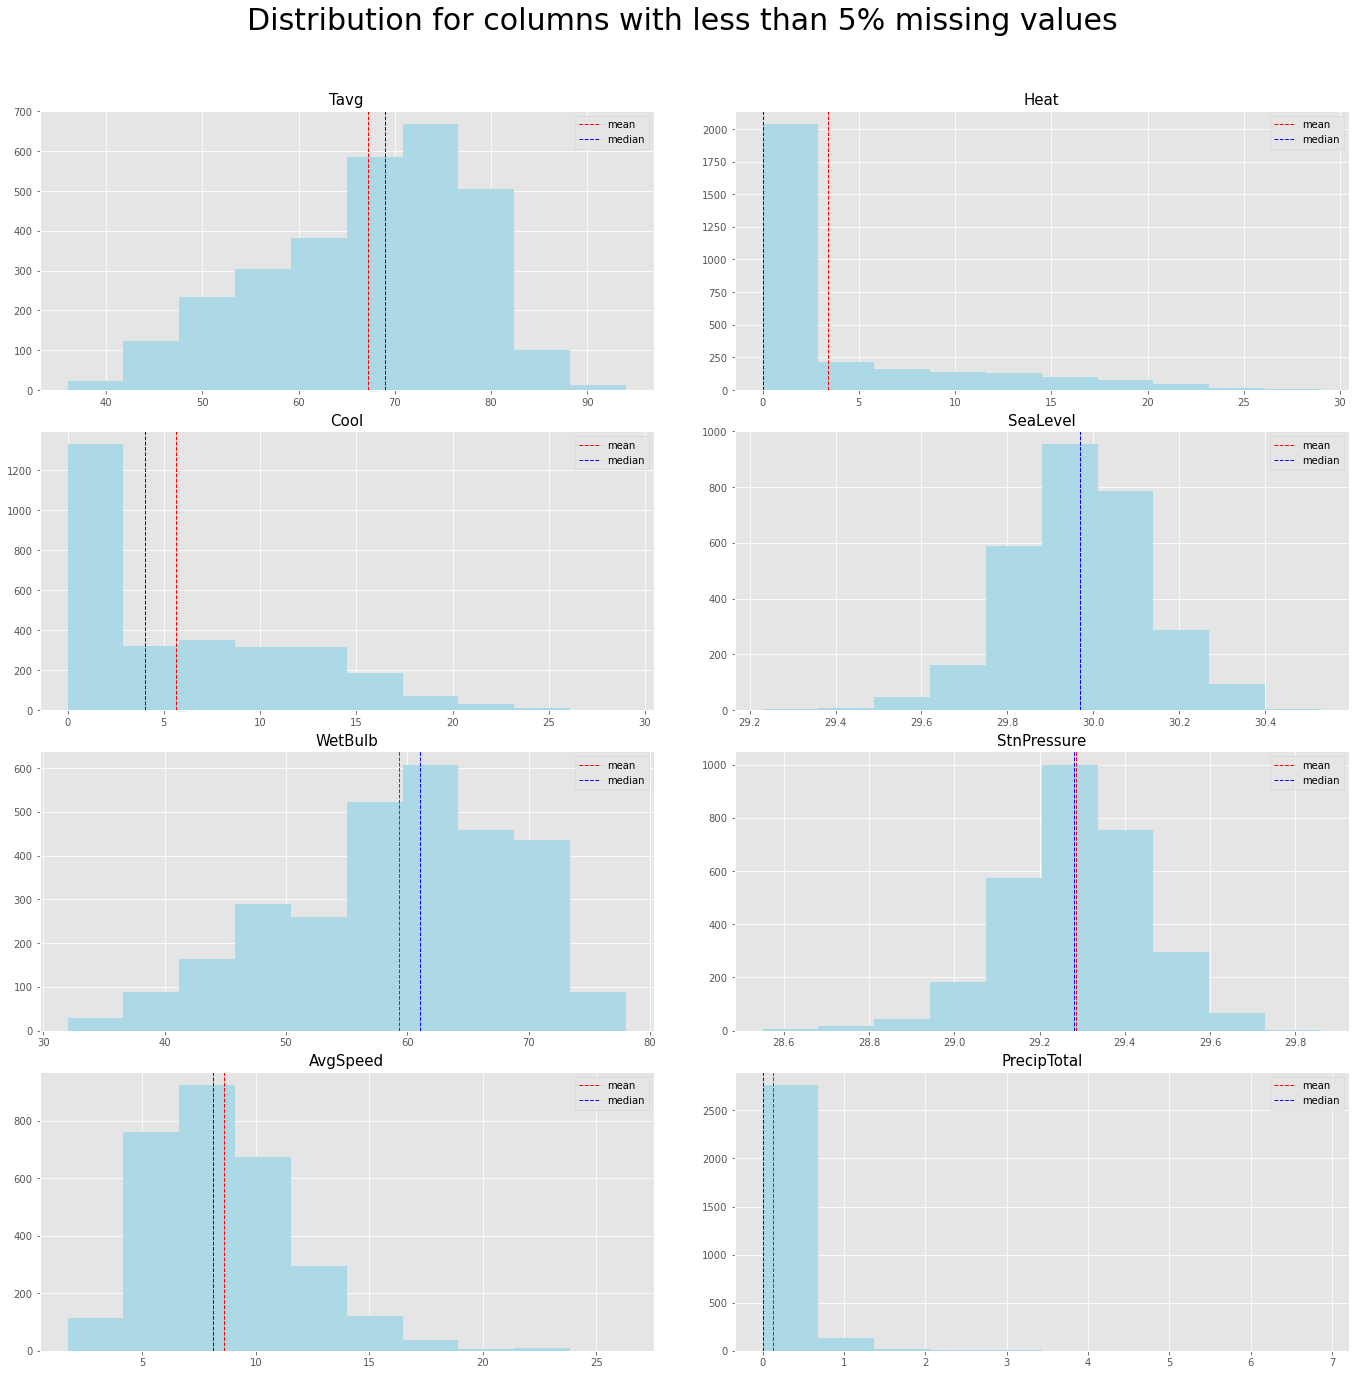

In [20]:
# Visualizing columns with less than 5% missing values
col_lessthan5 = ['Tavg', 'Heat', 'Cool','SeaLevel','WetBulb','StnPressure','AvgSpeed','PrecipTotal']  
subplot_hist(weather,col_lessthan5,"Distribution for columns with less than 5% missing values ", col_lessthan5,(20,20))

In [21]:
# Prints Median and Mean values for columns with less than 5% of all rows in the dataset as missing values
for i in col_lessthan5:
    print(i)
    print('Median:', weather[i].median(),'Mean:', round(weather[i].mean(),3))
# Click ... below to see output

Tavg
Median: 69.0 Mean: 67.24
Heat
Median: 0.0 Mean: 3.407
Cool
Median: 4.0 Mean: 5.647
SeaLevel
Median: 29.97 Mean: 29.968
WetBulb
Median: 61.0 Mean: 59.311
StnPressure
Median: 29.28 Mean: 29.284
AvgSpeed
Median: 8.1 Mean: 8.58
PrecipTotal
Median: 0.0 Mean: 0.131


Looking at the visualizations as well as the median and mean values, we observe the following distributions for these columns:   

**Negatively skewed distribution (Median > Mean):**
- Tavg
- Wetbulb

**Positively skewed distribution (Mean > Median):**
- Heat
- Cool
- AvgSpeed
- PrecipTotal

**Normal Distribution (Median ~ Mean, when rounded to 1 decimal place):**
- SeaLevel
- StnPressure

Based on these observations, columns with both positive and negatively skewed distributions will have their `np.nan` values imputed with their respective medians. Columns with normal distribution will have their `np.nan` values imputed with their respective means. 

The actual value of **'Tavg'** can be calculated by a such: **Tmax -Tmin / 2** which would provide more accurate values than using median.

In [22]:
# Imputing respective mean/median values for previously identified column distributions
median_impt_cols = ['WetBulb','Cool','Heat','AvgSpeed','PrecipTotal']
mean_impt_cols = ['SeaLevel','StnPressure']
median_imputer(weather, median_impt_cols)
mean_imputer(weather, mean_impt_cols)

In [23]:
# Imputing 'Tavg' using above mentioned formula,
weather['Tavg'] = weather['Tmax']-((weather['Tmax'] - weather['Tmin'])/2)
# Uncomment and run to check np.nan values after imputation
# weather.isnull().sum()

### EDA

As we converted our `weather['Date']` into `datetime` format earlier, we can use the `Datetime` libraries to extract the information into the various columns below.

In [24]:
# Creating Year, month Variable from Date
weather['Year'] = weather['Date'].dt.year 
weather['Month'] = weather['Date'].dt.month
weather['WeekofYear'] = weather['Date'].dt.isocalendar().week

With these columns created, we can now see relationships of our numerical columns over time more easily.

### Temperature Variables

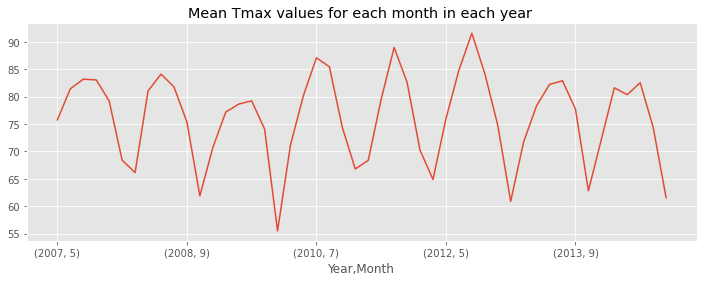

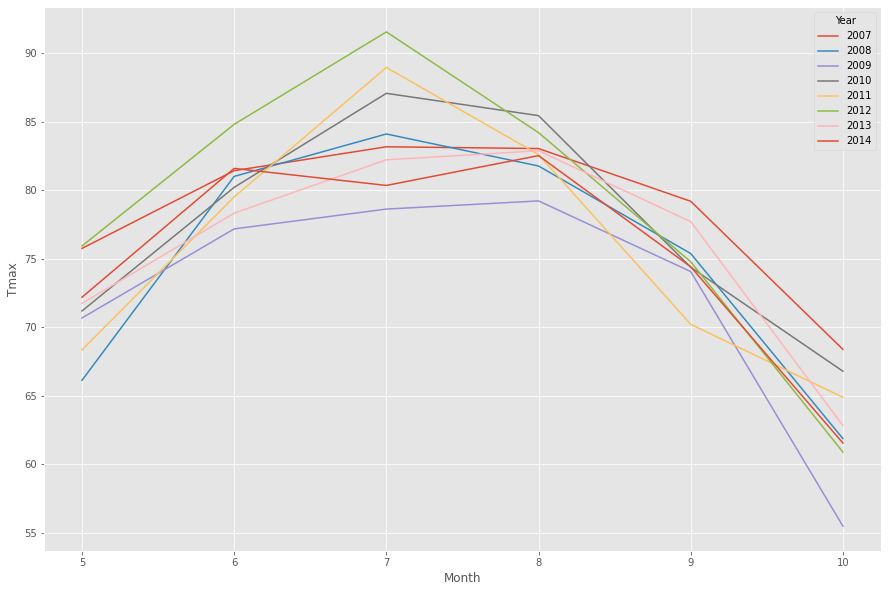

In [28]:
# Line plot visualization for mean monthly Tavg values across the years, followed by breakdown of each year
subplot_line('Tmax', weather)

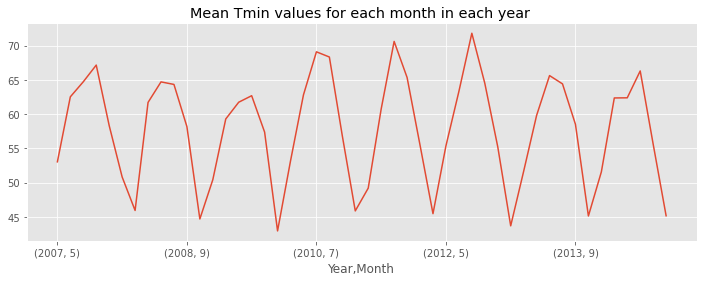

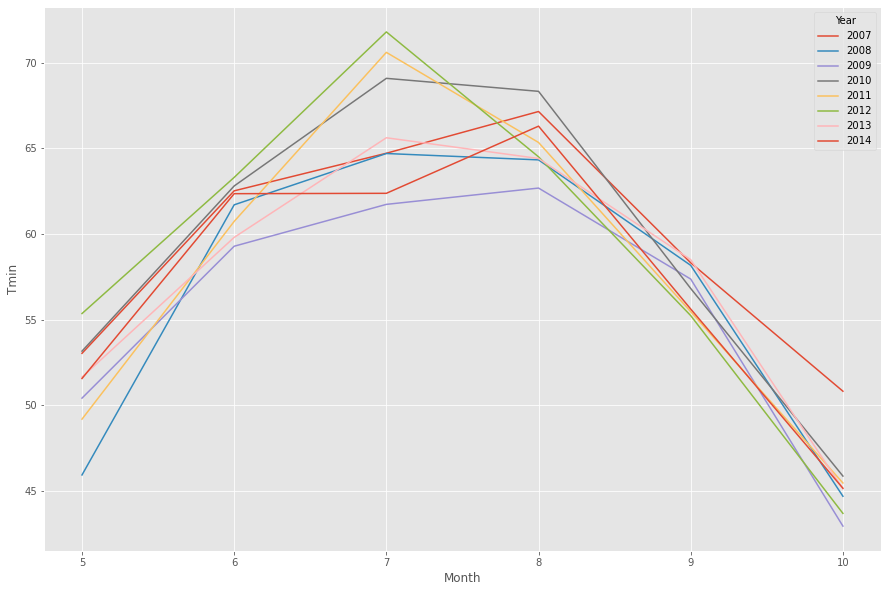

In [29]:
# Line plot visualization for mean monthly Tavg values across the years, followed by breakdown of each year
subplot_line('Tmin', weather)

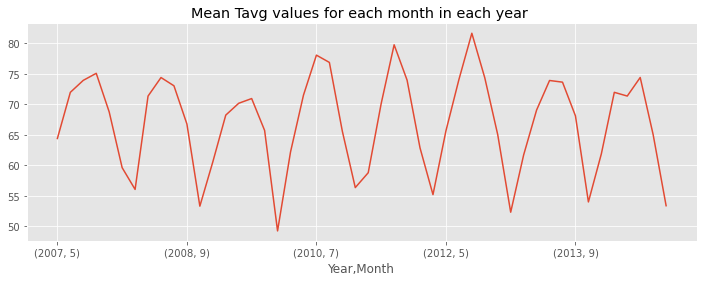

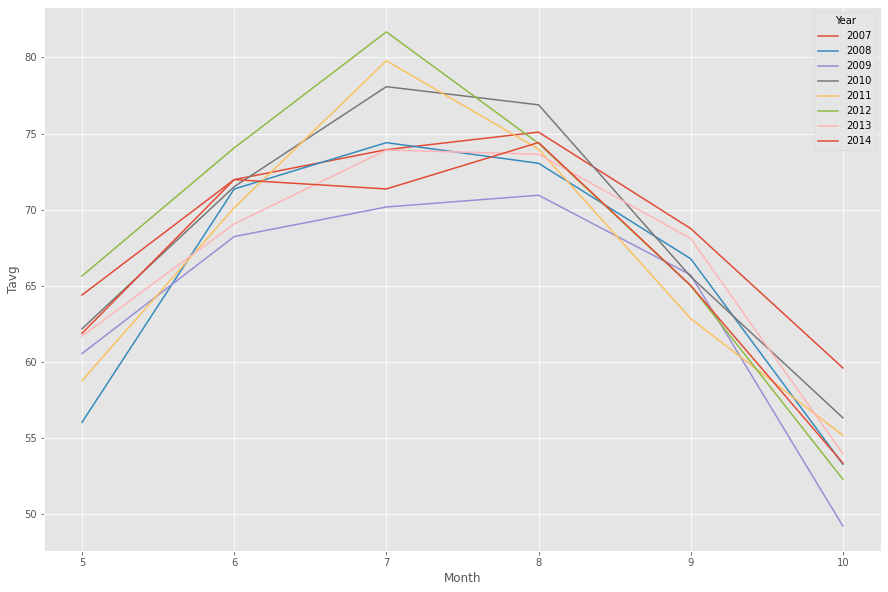

In [30]:
# Line plot visualization for mean monthly Tavg values across the years, followed by breakdown of each year
subplot_line('Tavg', weather)

#### Observations
There seems to be a pattern where temperature variable values are highest, usually either in the month of July or August, indicating some form of seasonality for all three of them if we look at the monthly mean values.  

- **July** in years *2008, 2010, 2011, 2012* 
- **August** in years *2007, 2009, 2013, 2014*

### Heat and Cool

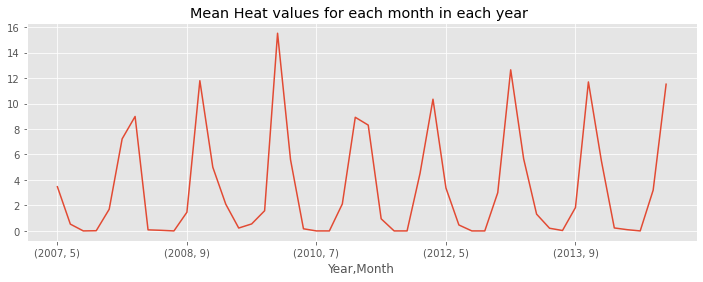

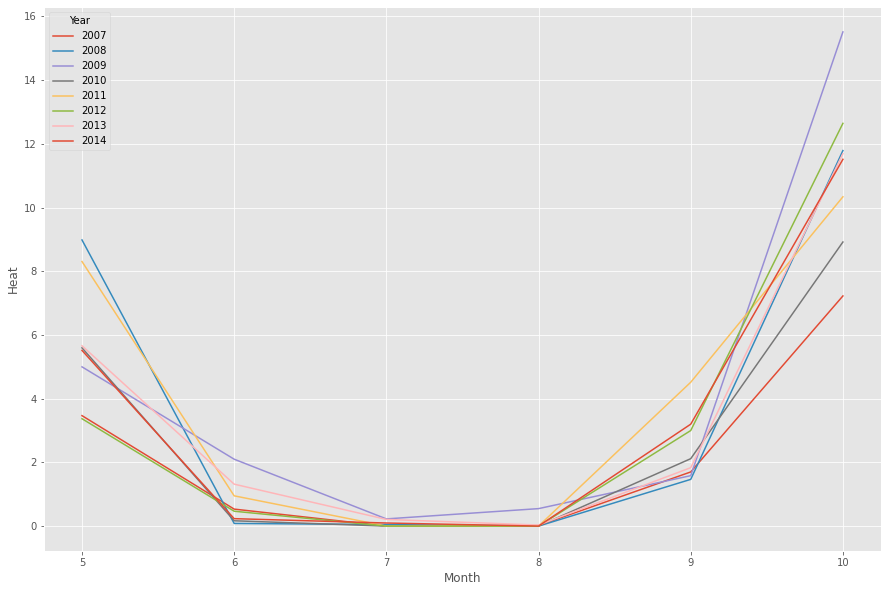

In [31]:
# Line plot visualization for mean monthly Heat values across the years, followed by breakdown of each year
subplot_line('Heat', weather)

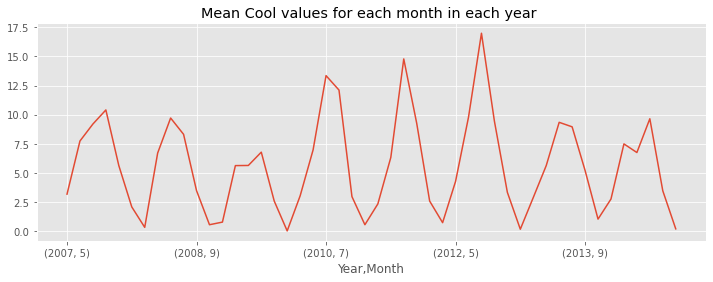

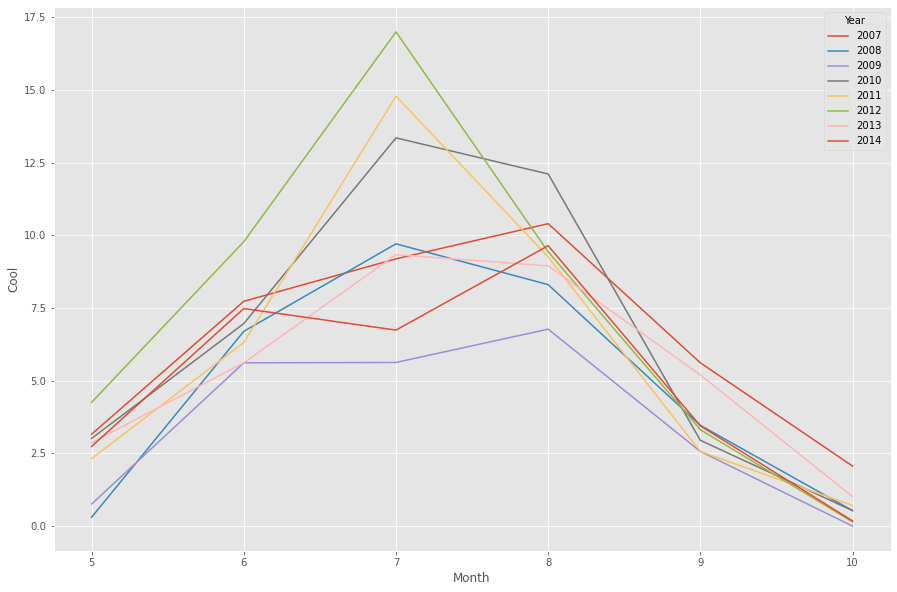

In [32]:
# Line plot visualization for mean monthly Cool values across the years, followed by breakdown of each year
subplot_line('Cool', weather)

#### Observations

According to the earlier attached [document](../files/weather_csv_readme.pdf) detailing the descriptions for the columns. `Heat` and `Cool` seem to track deviance from a specific temperature. While both of them exhibit traits of seasonality, they also seem to have an inverse relationship with one another (i.e Highest mean value for Heat will correspond to lowest mean value for Cool). As we have no idea what is the specified temperature by which the deviance is tracked, we can instead look at just the Tavg variable instead to indicate both hot or cold temperatures.


### DewPoint

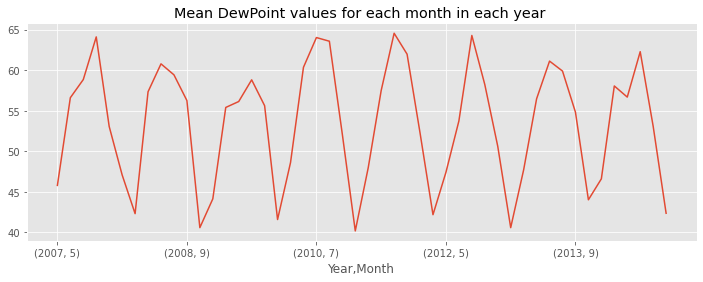

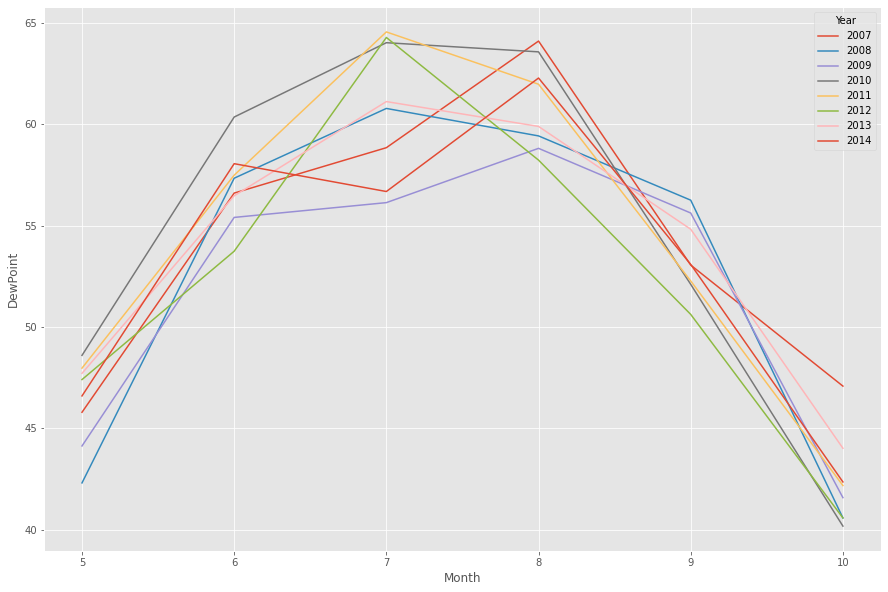

In [33]:
# Line plot visualization for mean monthly DewPoint values across the years, followed by breakdown of each year
subplot_line('DewPoint', weather)

#### Observations
There seems to be a pattern where DewPoint values are highest, usually either in the month of July or August, indicating some form of seasonality for DewPoint if we look at the monthly mean values.   
- **July** in years *2008, 2010, 2011, 2012, 2013* 
- **August** in years *2007, 2009, 2014*

### WetBulb

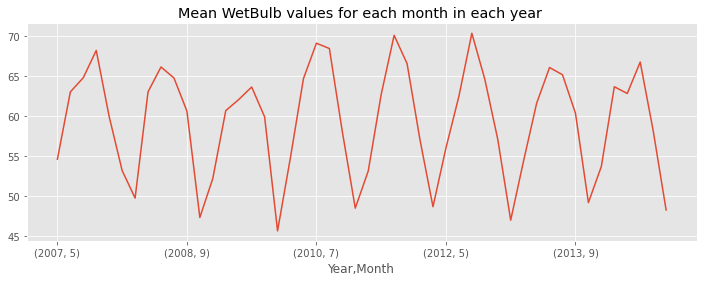

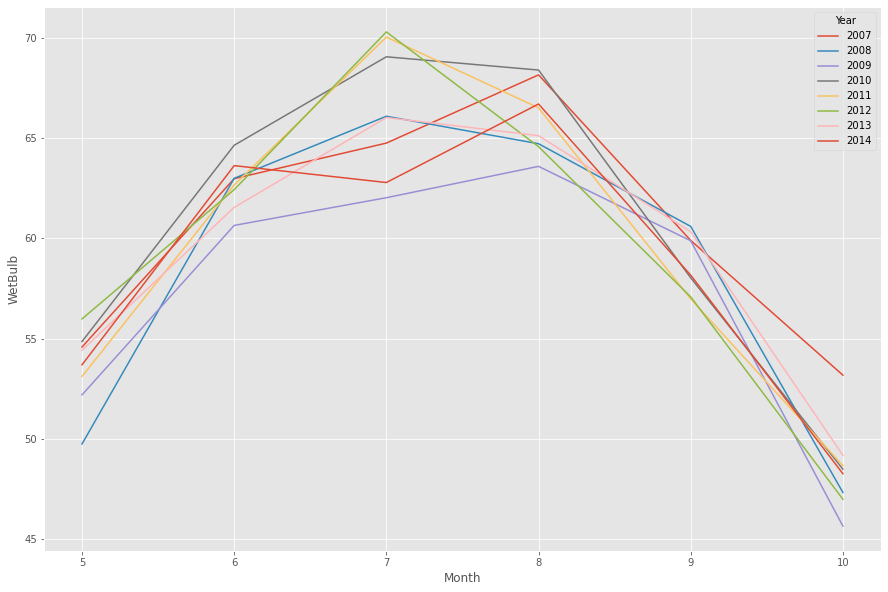

In [34]:
# Line plot visualization for mean monthly WetBulb values across the years, followed by breakdown of each year
subplot_line('WetBulb', weather)

#### Observations
There seems to be a pattern where WetBulb values are highest, usually either in the month of July or August, indicating some form of seasonality for WetBulb if we look at the monthly mean values.   
- **July** in years *2008, 2010, 2011, 2012, 2013* 
- **August** in years *2007, 2009, 2014*

Both WetBulb and Dewpoint seem to be telling the same story, which might be an indication that they might be highly correlated.

### PrecipTotal

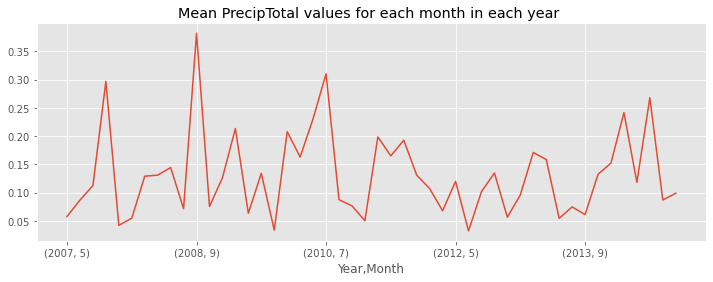

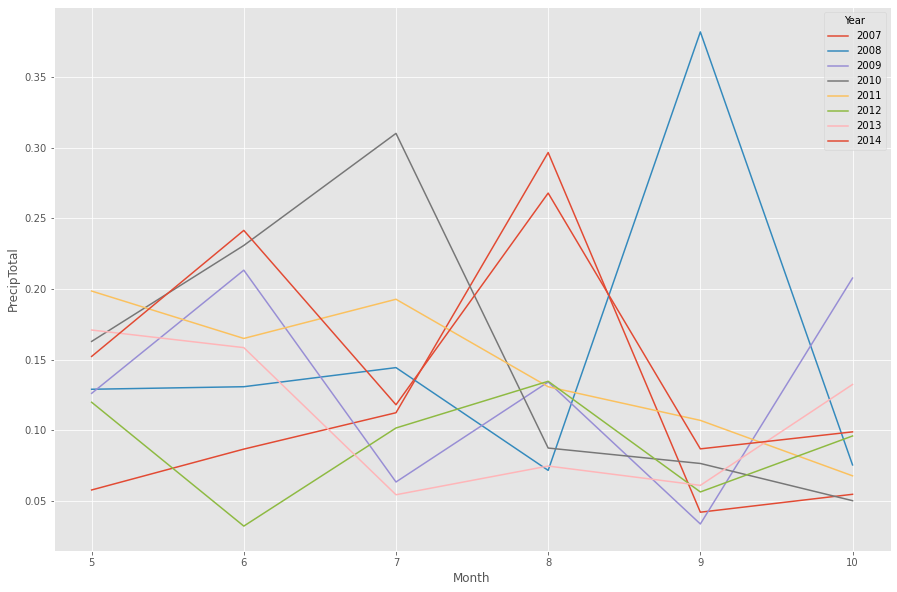

In [35]:
# Line plot visualization for mean monthly PrecipTotal values across the years, followed by breakdown of each year
subplot_line('PrecipTotal', weather)

#### Observations

- PrecipTotal highest values usually vary between the months of July or August  every year, with the exception of years 2008 (September), 2009 (June), 2010/2013 (May)

- It does not seem like PrecipTotal has any seasonality as there is no predictable mean values and months where it is consistent over a period of time.

- We feel that this feature might not be very helpful in helping us predict our dependent variable

### StnPressure

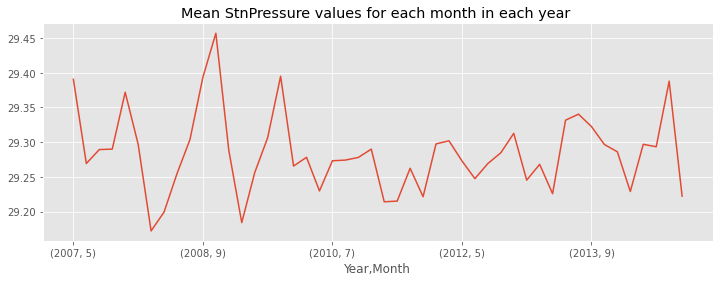

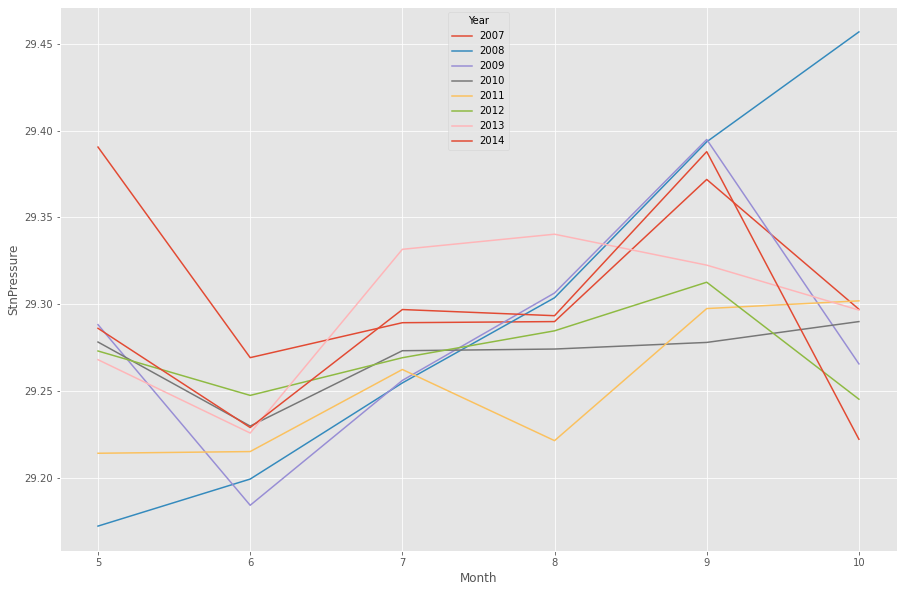

In [36]:
# Line plot visualization for mean monthly StnPressure values across the years, followed by breakdown of each year
subplot_line('StnPressure', weather)

#### Observations
- With the exception of year 2007, it seems that `StnPressure` values tend to be higher in the later months as compared to earlier months.

- A closer at the fluctuations of the values is within a range of 0.3 INCHES OF HG , which may have too little variability to provide us with useful information.

### SeaLevel

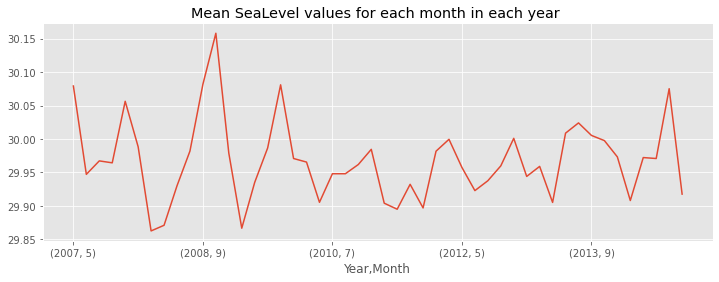

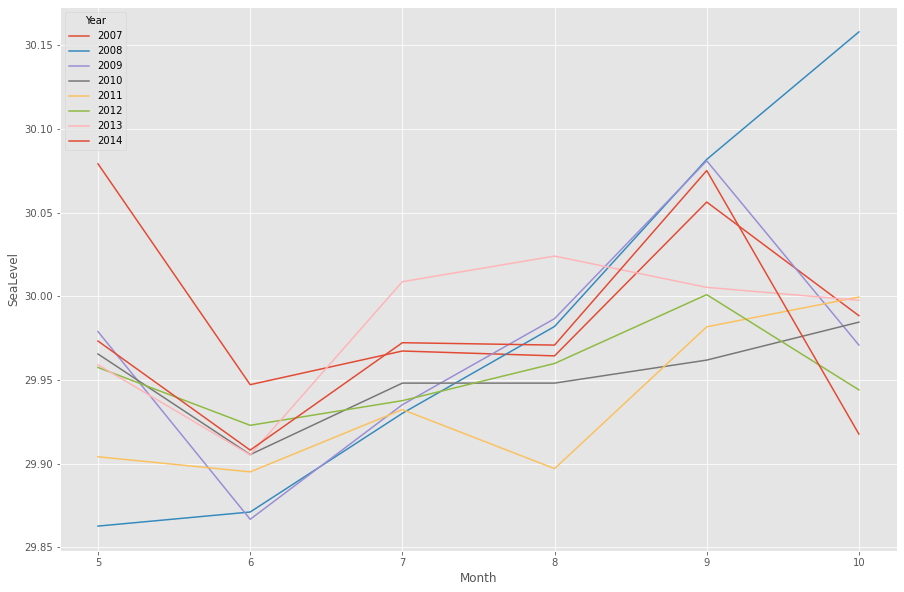

In [37]:
# Line plot visualization for mean monthly SeaLevel values across the years, followed by breakdown of each year
subplot_line('SeaLevel', weather)

#### Observations
- `SeaLevel` values tell's us a similar story to that of `StnPressure`, suggesting that the two may be collinear with one another.

- A closer at the fluctuations of the values is within a range of 0.4 inches, which may have too little variability to provide us with useful information.

### AvgSpeed

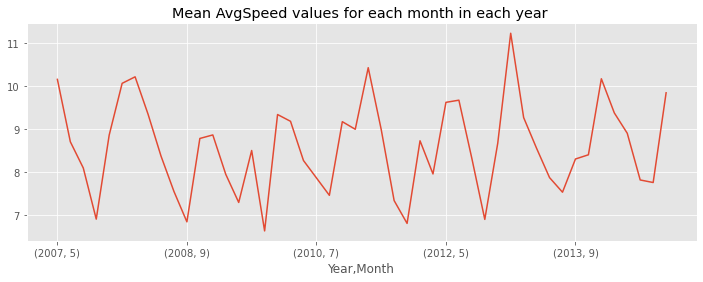

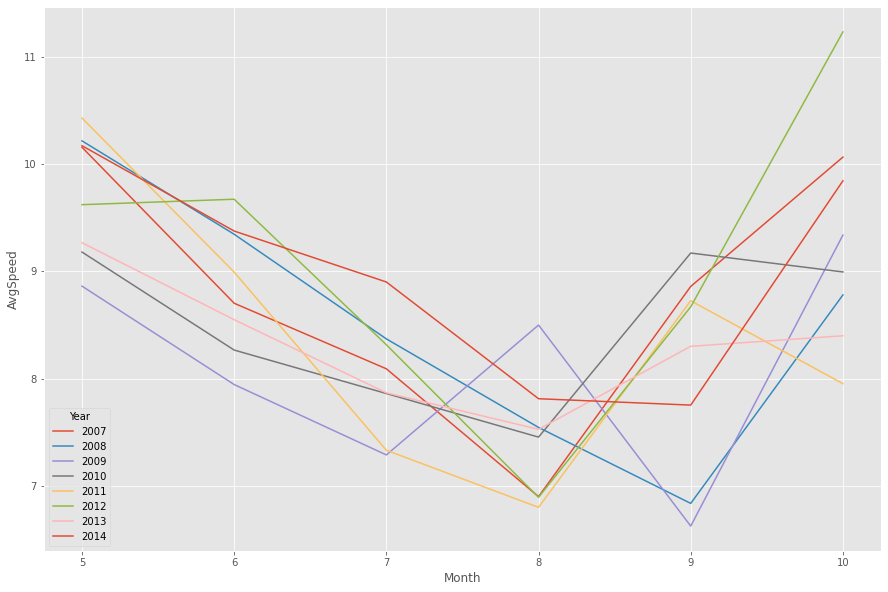

In [38]:
# Line plot visualization for mean monthly AvgSpeed values across the years, followed by breakdown of each year
subplot_line('AvgSpeed', weather)

#### Observations
- Lower values seem to consistent fall under the months of August and September, suggesting that there might be some seasonal relationship for AvgSpeed.


### ResultSpeed

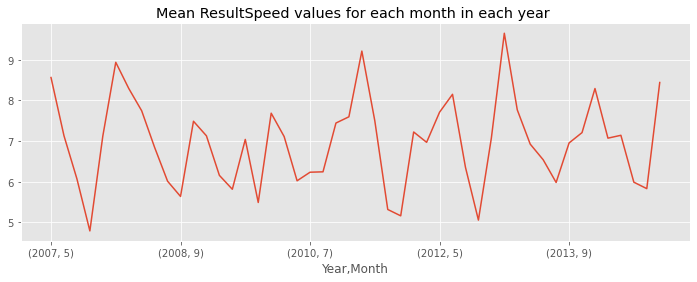

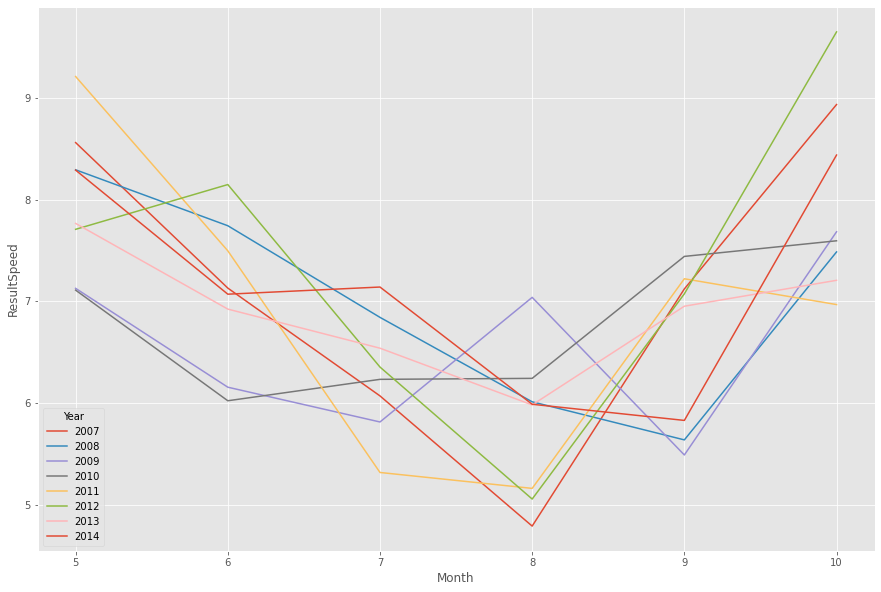

In [39]:
# Line plot visualization for mean monthly ResultSpeed values across the years, followed by breakdown of each year
subplot_line('ResultSpeed', weather)

#### Observations
- Lower values seem to consistent fall under the months of August and September, suggesting that there might be some seasonal relationship for ResultSpeed, a notable exception is for the year of 2010 where the lowest mean ResultSpeed was logged in the month of June.

As both are speed variables, it is natural for both of them to be telling a similar story, which might be an indication that they are highly correlated with one another.

### ResultDir

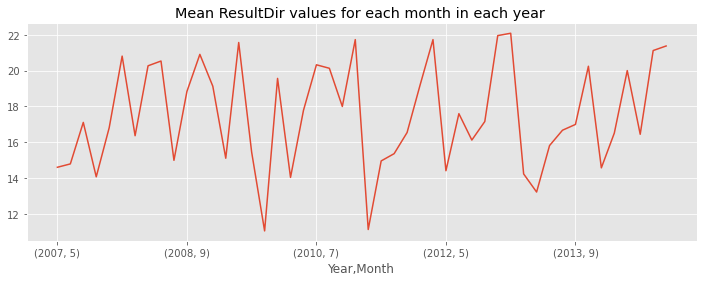

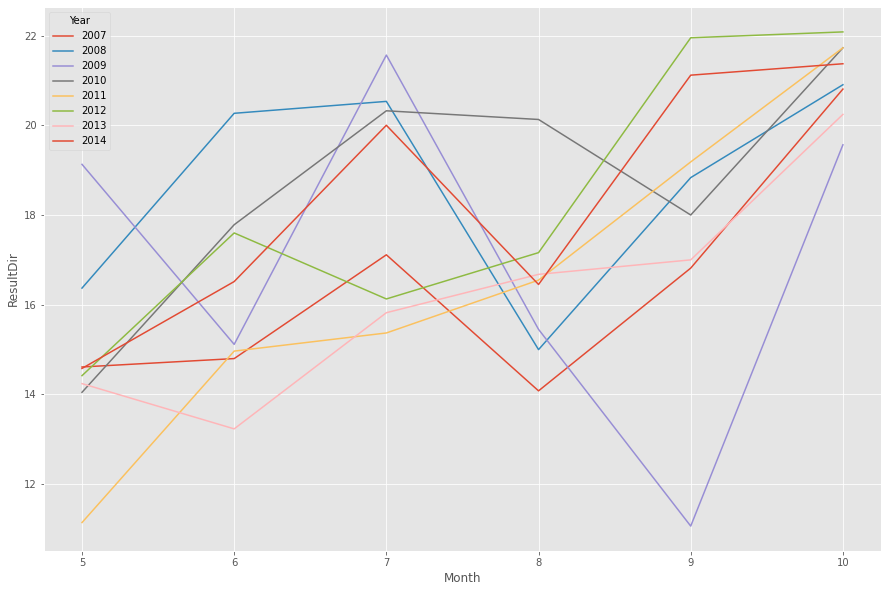

In [40]:
# Line plot visualization for mean monthly ResultDir values across the years, followed by breakdown of each year
subplot_line('ResultDir', weather)

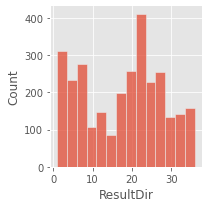

In [41]:
# Histogram plot for ResultDir
sns.displot(weather['ResultDir'], kind = 'hist', height = 3);

### Observations
- As we know that the degrees are rounded to the nearest tenth of a degree, thus we should not look at the values of ResultDir at face value. We should consider the following values with their general directions on the compass:

    - North: 36
    - East: 9 
    - South: 18 
    - West: 27 

Looking at the distribution, we can see that winds blow most often in the top 3 directions of:  

- South-Southwest (~21) 
- North-Northeast (~3)
- East-Northeast (~7.5).

### Daylight variables

With the `Sunset` and `Sunrise` columns for station 2 imputed using our calculated values, we engineer a feature named `Daylight_Hours` to more intuitively approximate mosquito behaviour, specifically feeding. 
  
With reference to the [literature](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3904402/), blood feeding by free-living insect vectors of disease is rhythmic and can be used to predict when infectious bites will occur. 

In [42]:
# Convert sunrise_ time values to datetime
sunrise_time = []
for val in weather['Sunrise']:
    date_val = dt.datetime.strptime(val, '%H%M')
    sunrise_time.append(date_val.hour + date_val.minute/60)
    
sunset_time = []
for val in weather['Sunset']:
    try:
        date_val = dt.datetime.strptime(val, '%H%M')
        sunset_time.append(date_val.hour + date_val.minute/60)
    except:
        date_val = dt.datetime.strptime(val.replace('60', '59'), '%H%M')
        sunset_time.append(date_val.hour + date_val.minute/60)
        
# Transform values to hours from midnight
weather['Sunrise'] = sunrise_time
weather['Sunset'] = sunset_time

In [43]:
# Create new feature for sun hours
weather['Daylight_Hours'] = weather['Sunset'] - weather['Sunrise']

Lets take a look at the distribution of the newly created `Daylight_Hours`,

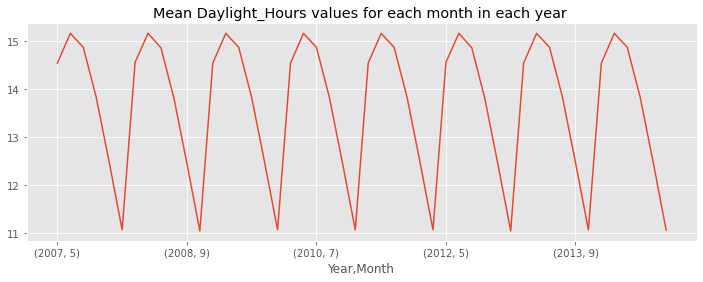

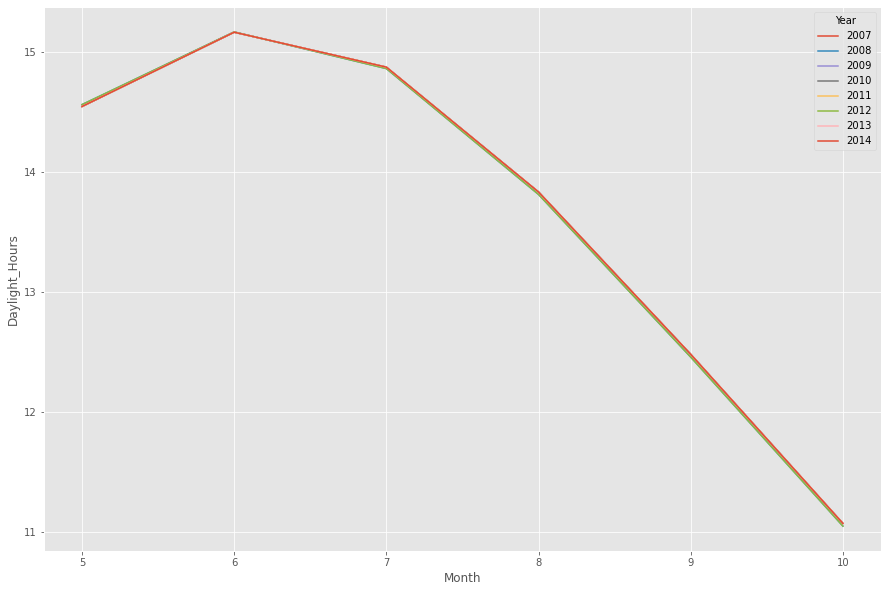

In [44]:
# Line plot visualization for mean Daylight_Hours values in each month for a given year
subplot_line('Daylight_Hours', weather)

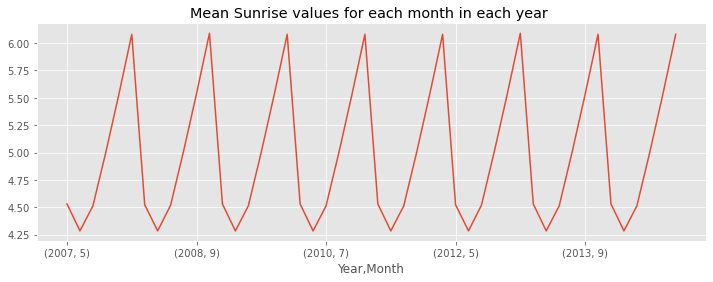

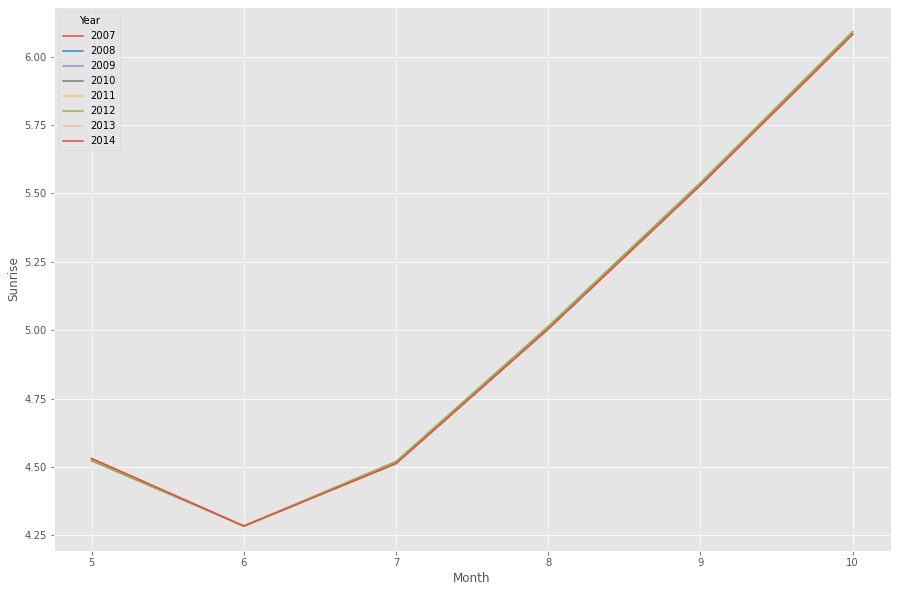

In [45]:
# Line plot visualization for mean Daylight_Hours values in each month for a given year
subplot_line('Sunrise', weather)

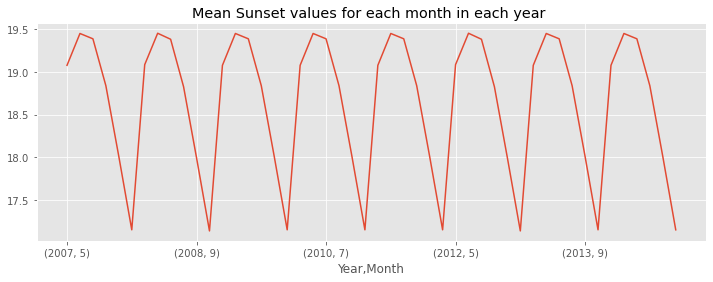

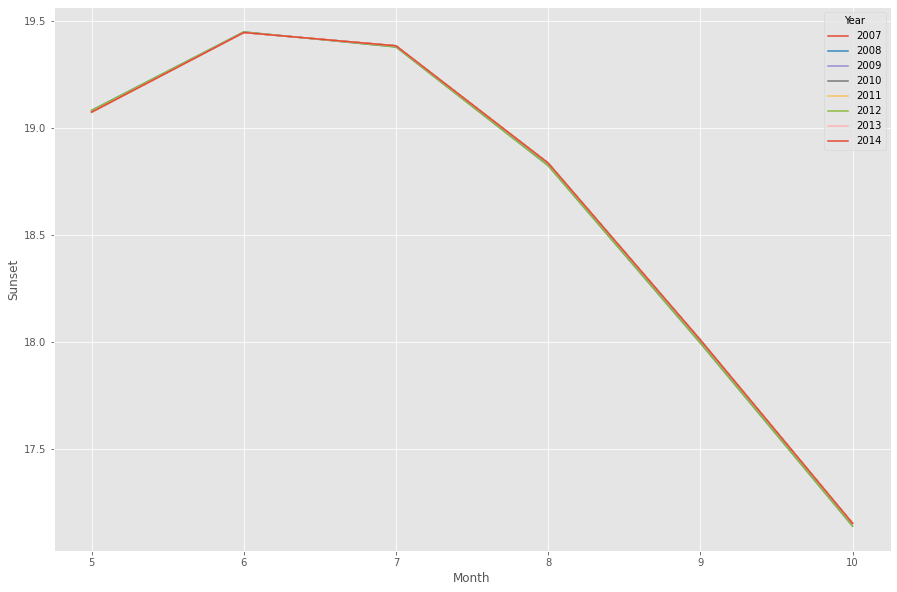

In [46]:
# Line plot visualization for mean Daylight_Hours values in each month for a given year
subplot_line('Sunset', weather)

#### Observations
- It seems that for every year from 2007-2014, we have higher relative daylight hours for the months of May and June, peaking in June, followed by a gradual decrease in the ensuing months after June, there is also definitive evidence to show that there is seasonality.

All three daylight related variables seems to be saying the same story, with the exception of Sunrise which its relationship is the inverse of SunSet and Daylight_hours.

### CodeSums

In [47]:
# Filtering/Masking out categories with < 1% missing values and storing as variable
weather['CodeSum'].value_counts(normalize = True)[weather['CodeSum'].value_counts(normalize = True) > 0.01]
cs_cat_percent = weather['CodeSum'].value_counts(normalize = True)[weather['CodeSum'].value_counts(normalize = True) > 0.01]
cs_cat_percent = cs_cat_percent.sort_values(ascending = False) * 100
cs_cat_percent
# Click ... below to see output

              54.653533
RA            10.054348
RA BR          8.084239
BR             3.736413
TSRA RA BR     3.125000
BR HZ          2.751359
RA DZ BR       2.207880
TSRA RA        1.460598
HZ             1.324728
RA BR HZ       1.290761
TSRA           1.154891
Name: CodeSum, dtype: float64

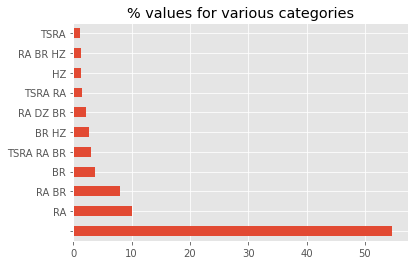

In [48]:
# Barplot for value percentages of all entries
cs_cat_percent.plot(kind = 'barh',title = '% values for various categories');

#### Observations
- We have more than 50% values which are ' ', signifying normal weather conditions. 
- There are over 30 different CodeSums for different conditions, with many of the combinations having RA (Rain) co-occuring across categories, which is not useful to have many categories to mean the same thing.
- It might make more sense to remap/ group the categories in this column into (Wet : 1 / Non-Wet : 0) conditions to better amplify the signal and filter out the noise.

In [49]:
# Creating list containing Codesums, decribing wet weather
code_sums = []
wet_codes = ['RA', 'TS', 'DZ', 'BR', 'UP', 'SH']

for code in weather['CodeSum']:
    code.replace('+', ' ')
    code_row = code.split()
    check_wet = 0
    for val in code_row:
        val_2 = None
        if len(val) > 2:
            val_1 = val[:2]
            val_2 = val[2:]
        else:
            val_1 = val
        
        if val_1 in wet_codes or val_2 in wet_codes:
            check_wet = 1

    code_sums.append(check_wet)

# Replace CodeSum column
weather['CodeSum'] = code_sums
weather.rename(columns={'CodeSum': 'Wet_NoWet'}, inplace=True)

In [50]:
weather['Wet_NoWet'].value_counts(normalize = True)

0    0.560802
1    0.439198
Name: Wet_NoWet, dtype: float64

We now have a more balanced representation of wet weather conditions against non-wet weather conditions, it should also be more easily understood by our model implemented later on.

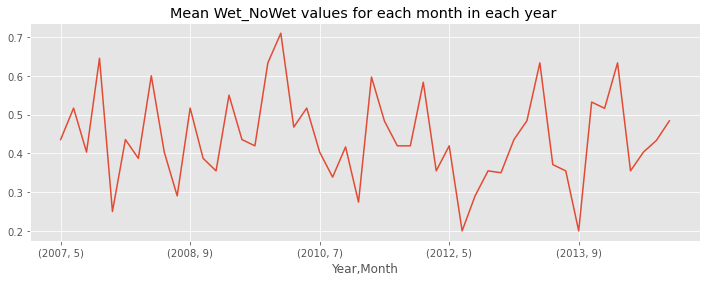

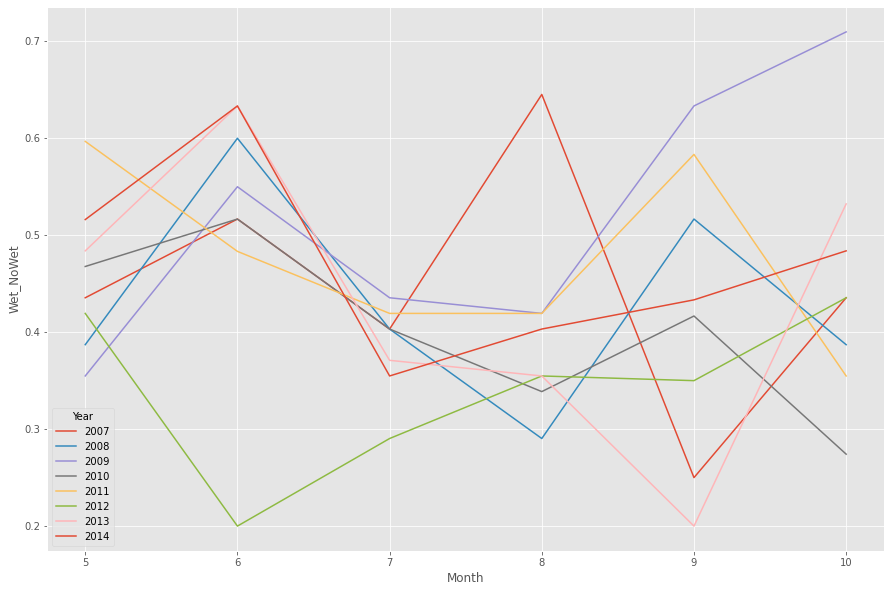

In [51]:
# Line plot visualization for mean monthly PrecipTotal values across the years, followed by breakdown of each year
subplot_line('Wet_NoWet', weather)

Looking at the breakdown by months for each year, we can also see that the tendency to observe wet weather phenomenons are higher in the months of June and September, with the exception of these months in the following years:  
- June in 2012 
- August in 2014

## Correlation between variables in dataset

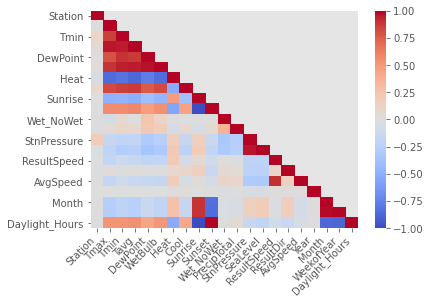

In [52]:
# Plotting Variables against one another in a correlation heatmap 
corr = weather.corr(method = 'pearson')
np.tril(np.ones(corr.shape)).astype('bool')[0:5,0:5] # Creating mask for upper triangle
df_lt = corr.where(np.tril(np.ones(corr.shape)).astype('bool')) # Applying mask for upper triangle
hmap=sns.heatmap(df_lt,vmin=-1,vmax=1,cmap='coolwarm') # using masked corr.df to plot 'half' heatmap
hmap.set_xticklabels(hmap.get_xticklabels(), rotation=45, horizontalalignment='right');

In [53]:
# Top 30 correlated variables
s = corr.abs().unstack()
so = s[s.sort_values(ascending = False) != 1]
so.sort_values(ascending = False).head(30)
# Click ... to see output

Sunset          Daylight_Hours    0.997224
Daylight_Hours  Sunset            0.997224
Sunrise         Daylight_Hours    0.995329
Daylight_Hours  Sunrise           0.995329
Sunrise         Sunset            0.985378
Sunset          Sunrise           0.985378
WeekofYear      Month             0.984700
Month           WeekofYear        0.984700
DewPoint        WetBulb           0.972341
WetBulb         DewPoint          0.972341
Tmax            Tavg              0.967861
Tavg            Tmax              0.967861
StnPressure     SeaLevel          0.967305
SeaLevel        StnPressure       0.967305
WetBulb         Tavg              0.960877
Tavg            WetBulb           0.960877
Tmin            Tavg              0.960682
Tavg            Tmin              0.960682
Tmin            WetBulb           0.951195
WetBulb         Tmin              0.951195
AvgSpeed        ResultSpeed       0.909736
ResultSpeed     AvgSpeed          0.909736
Sunrise         WeekofYear        0.906102
WeekofYear 

### Observations
- We may want to explore feature reduction to eliminate some of these variables as there seems to be some overlapping relationships which may confuse the model if we use all of them. This will be explored further in feature selection as part of the pre-processing steps prior to modelling.

- If we group the variables based on what they are trying to measure, we get the following groups:
    - **Temperature**: Tmax, Tmin, Tavg, Heat, Cool
    - **Humidity**: Dewpoint, Wetbulb
    - **Time**: Sunrise, Sunset, Daylight_Hours
    - **Pressure**: StnPressure, SeaLevel
    - **Wind Speed**: AvgSpeed, ResultSpeed
    - **Wind Direction**: ResultDir
    - **Wet Weather**: Wet_NoWet, PrecipTotal

- To reduce multi-collinearity, we should keep strive to keep just 1 variable from each group when we are considering the variables for modelling.

### Exporting to csv

In [54]:
# Save cleaned dataset as a csv file
weather.to_csv('../data/weather_clean.csv', index=False)